In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

%matplotlib inline

## Load the MIMIC data

In [2]:
df = pd.read_csv('../data/MIMIC_train_test.csv')
df.drop(columns='Unnamed: 0',inplace=True)

In [3]:
df.shape

(6483, 3)

## Prepare Text Data for Machine Learning

In [4]:
# The base line for this dataset
base = round(len(df[df['label']==0])/(len(df)),4)
print(f'The base line is {base}')

The base line is 0.9267


In [5]:
# Split the train and test data
X = df['text_list']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42)

In [6]:
y.value_counts()

0    6008
1     475
Name: label, dtype: int64

In [7]:
y_train.value_counts(normalize=True)

0    0.925134
1    0.074866
Name: label, dtype: float64

In [8]:
y_test.value_counts(normalize=True)

0    0.931524
1    0.068476
Name: label, dtype: float64

## Vectorization NLP 

In [9]:
# Create a function to fit and transform dataset to 2 kinds of Vectorizer
def vectorizing(vec_name):
    return vec_name.fit_transform(X_train), vec_name.transform(X_test)

In [10]:
# Use default CountVectorizer and TfidfVecterizer parameter
# The default parameter won't work, because model failed to converge
# Use max_features = 200
cvec = CountVectorizer(max_features=100, stop_words='english')
X_train_cvec, X_test_cvec = vectorizing(cvec)
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_train_tfidf, X_test_tfidf = vectorizing(tfidf)

In [11]:
y_test.shape

(1621,)

### CountVectorizer, Train & Test

In [12]:
# Create the balanced training set and testing set seperately
smt = SMOTE()
X_train_cvec, y_train_cvec = smt.fit_sample(X_train_cvec, y_train)
y_train_cvec.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [13]:
X_test_cvec, y_test_cvec = smt.fit_sample(X_test_cvec, y_test)
y_test_cvec.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [14]:
print(X_train_cvec.shape, X_test_cvec.shape, y_train_cvec.shape, y_test_cvec.shape)

(8996, 100) (3020, 100) (8996,) (3020,)


### TfidfVectorizer, Train & Test

In [15]:
# Create the balanced training set and testing set seperately
smt = SMOTE()
X_train_tfidf, y_train_tfidf = smt.fit_sample(X_train_tfidf, y_train)
y_train_tfidf.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [16]:
X_test_tfidf, y_test_tfidf = smt.fit_sample(X_test_tfidf, y_test)
y_test_tfidf.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [17]:
print(X_train_tfidf.shape, X_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape)

(8996, 100) (3020, 100) (8996,) (3020,)


In [19]:
# Create a dataframe to show the words features used in training set
X_train_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names())
names = list(X_train_df.columns)
names[0]

'acute'

## Machine Learning Classification Models: Logistic Regression

In [42]:
model_lg = LogisticRegression(C=0.001)
model_lg.fit(X_train_cvec, y_train_cvec)

/Users/susanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp 

In [60]:
model_lg = LogisticRegression()
cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp = model_work(model_lg, 
                                                                                             X_train_tfidf,
                                                                                             y_train,
                                                                                             X_test_tfidf,
                                                                                             y_test)

/Users/susanchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [67]:
cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp

(0.9177, 0.9255, 0.9229, 0.0, 0.990728476821192, 0.0, 0, 14)

### The Logistic Regression model kept fail to converge. The results are not reliable. I won't include this model in my model comparison.

## Machine Learning Classification Models: Random Forest

In [24]:
# Model work with balanced CountVecoterizing data
model_rf1 = RandomForestClassifier(n_estimators=50, max_depth=2)
model_rf1.fit(X_train_cvec, y_train_cvec)
cross_val_acc1 = round(cross_val_score(model_rf1, X_train_cvec, y_train_cvec).mean(),4)
train_acc1 = round(model_rf1.score(X_train_cvec,y_train_cvec),4)
test_acc1 = round(model_rf1.score(X_test_cvec,y_test_cvec),4)
preds1 = model_rf1.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds1).ravel()
print(f' cross_val_acc = {cross_val_acc1}\n train_acc = {train_acc1} \n test_acc = {test_acc1}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.6944
 train_acc = 0.698 
 test_acc = 0.6424
 tn, fp, fn, tp (910, 600, 480, 1030)


In [25]:
# Model work with balanced TfidfVecoterizing data
model_rf2 = RandomForestClassifier(n_estimators=50, max_depth=2)
model_rf2.fit(X_train_tfidf, y_train_tfidf)
cross_val_acc2 = round(cross_val_score(model_rf2, X_train_tfidf, y_train_tfidf).mean(),4)
train_acc2 = round(model_rf2.score(X_train_tfidf,y_train_tfidf),4)
test_acc2 = round(model_rf2.score(X_test_tfidf,y_test_tfidf),4)
preds2 = model_rf2.predict(X_test_tfidf)
tn, fp, fn, tp = confusion_matrix(y_test_tfidf, preds2).ravel()
print(f' cross_val_acc = {cross_val_acc2}\n train_acc = {train_acc2} \n test_acc = {test_acc2}\n tn, fp, fn, tp {tn, fp, fn, tp}' )


 cross_val_acc = 0.7702
 train_acc = 0.7904 
 test_acc = 0.7858
 tn, fp, fn, tp (1113, 397, 250, 1260)


In [27]:
feature_importance_tup = sorted(zip(map(lambda x: round(x, 4), model_rf2.feature_importances_), names), reverse=True)
feature_importance_tup[:10]

[(0.1032, 'negative'),
 (0.0829, 'noted'),
 (0.0663, 'unit'),
 (0.0661, 'pulmonary'),
 (0.066, 'units'),
 (0.0645, 'iv'),
 (0.0608, 'given'),
 (0.0496, 'prior'),
 (0.0451, 'insulin'),
 (0.0405, 'continued')]

## Machine Learning Classification Models: Multinomial Naive Bayes

In [30]:
# Model work with balanced CountVecoterizing data
model_nb1 = MultinomialNB()
model_nb1.fit(X_train_cvec,y_train_cvec)
cross_val_acc3 = round(cross_val_score(model_nb1, X_train_cvec, y_train_cvec).mean(),4)
train_acc3 = round(model_nb1.score(X_train_cvec,y_train_cvec),4)
test_acc3 = round(model_nb1.score(X_test_cvec,y_test_cvec),4)
preds3 = model_nb1.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds3).ravel()
print(f' cross_val_acc = {cross_val_acc3}\n train_acc = {train_acc3} \n test_acc = {test_acc3}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.648
 train_acc = 0.6498 
 test_acc = 0.6192
 tn, fp, fn, tp (912, 598, 552, 958)


In [31]:
# Model work with balanced TfidfVecoterizing data
model_nb2 = MultinomialNB()
model_nb2.fit(X_train_tfidf,y_train_tfidf)
cross_val_acc4 = round(cross_val_score(model_nb2, X_train_tfidf, y_train_tfidf).mean(),4)
train_acc4 = round(model_nb2.score(X_train_tfidf,y_train_tfidf),4)
test_acc4 = round(model_nb2.score(X_test_tfidf,y_test_tfidf),4)
preds4 = model_nb2.predict(X_test_tfidf)
tn, fp, fn, tp = confusion_matrix(y_test_tfidf, preds4).ravel()
print(f' cross_val_acc = {cross_val_acc4}\n train_acc = {train_acc4} \n test_acc = {test_acc4}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.614
 train_acc = 0.6149 
 test_acc = 0.5497
 tn, fp, fn, tp (848, 662, 698, 812)


## Machine Learning Classification Models: XG Boost

### CountVectorizer

In [50]:
# Model work with balanced CountVecoterizing data
model_xg1 = XGBClassifier()
model_xg1.fit(X_train_cvec, y_train_cvec)
cross_val_acc5 = round(cross_val_score(model_xg1, X_train_cvec, y_train_cvec).mean(),4)
train_acc5 = round(model_xg1.score(X_train_cvec,y_train_cvec),4)
test_acc5 = round(model_xg1.score(X_test_cvec,y_test_cvec),4)
preds5 = model_xg1.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds5).ravel()
print(f' cross_val_acc = {cross_val_acc5}\n train_acc = {train_acc5} \n test_acc = {test_acc5}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.9578
 train_acc = 0.9581 
 test_acc = 0.9609
 tn, fp, fn, tp (1510, 0, 118, 1392)


In [35]:
pred_proba_xg1 = [i[1] for i in model_xg1.predict_proba(X_test_cvec)]
pred_xg1_df = pd.DataFrame({'true_values': y_test_cvec,
                        'pred_probs':pred_proba_xg1})

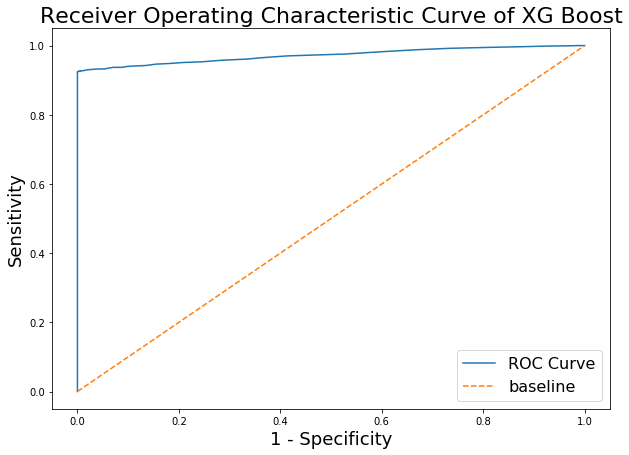

In [39]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 201)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_xg1_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_xg1_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve of XG Boost', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [34]:
# Model work with balanced TfidfVecoterizing data
model_xg2 = XGBClassifier()
model_xg2.fit(X_train_tfidf, y_train_tfidf)
cross_val_acc6 = round(cross_val_score(model_xg2, X_train_tfidf, y_train_tfidf).mean(),4)
train_acc6 = round(model_xg2.score(X_train_tfidf,y_train_tfidf),4)
test_acc6 = round(model_xg2.score(X_test_tfidf,y_test_tfidf),4)
preds6 = model_xg2.predict(X_test_tfidf)
tn, fp, fn, tp = confusion_matrix(y_test_tfidf, preds6).ravel()
print(f' cross_val_acc = {cross_val_acc6}\n train_acc = {train_acc6} \n test_acc = {test_acc6}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.9299
 train_acc = 0.9454 
 test_acc = 0.9093
 tn, fp, fn, tp (1455, 55, 219, 1291)


In [36]:
pred_proba_xg2 = [i[1] for i in model_xg2.predict_proba(X_test_tfidf)]
pred_xg2_df = pd.DataFrame({'true_values': y_test_tfidf,
                        'pred_probs':pred_proba_xg2})

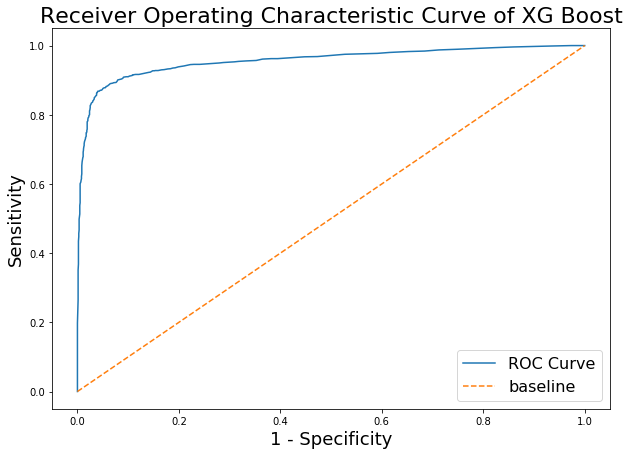

In [40]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 201)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_xg2_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_xg2_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve of XG Boost', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [64]:
feature_importance_xg = sorted(zip(map(lambda x: round(x, 4), model_xg1.feature_importances_), names), reverse=True)
feature_importance_xg[:10]

[(0.062, 'hypertension'),
 (0.0534, 'cardiac'),
 (0.0496, 'noted'),
 (0.0455, 'heart'),
 (0.0424, 'weeks'),
 (0.0364, 'iv'),
 (0.0361, 'namepattern1'),
 (0.0347, 'inr'),
 (0.0322, 'location'),
 (0.0318, 'pressure'),
 (0.0296, 'aspirin'),
 (0.0295, 'insulin'),
 (0.0287, 'transferred'),
 (0.0279, 'acute'),
 (0.0264, 'surgery')]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


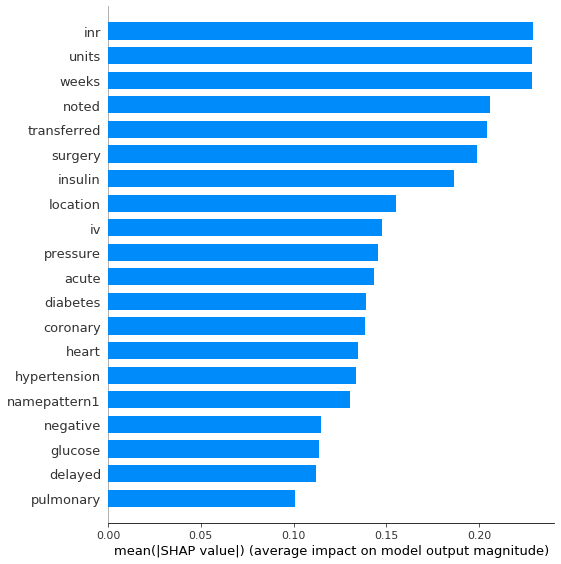

In [41]:
import shap
shap_values = shap.TreeExplainer(model_xg1).shap_values(X_train_cvec)
shap.summary_plot(shap_values, X_train_cvec, plot_type="bar", feature_names=cvec.get_feature_names())

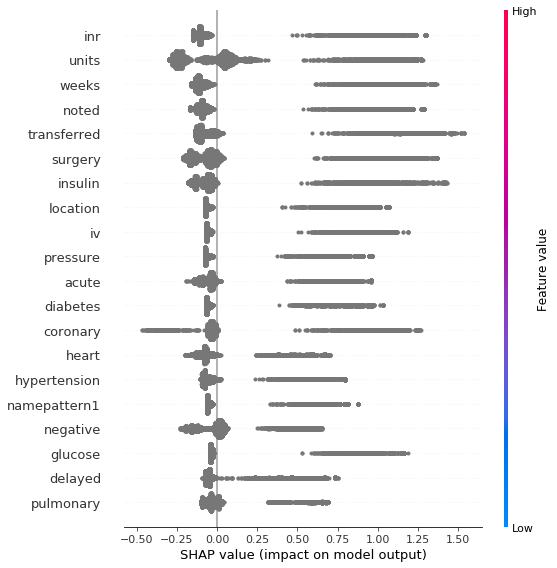

In [42]:
shap.summary_plot(shap_values, X_train_cvec,feature_names=cvec.get_feature_names())

## Machine Learning Classification Models: SVM

In [52]:
# Model work with balanced CountVecoterizing data
model_svc1 = SVC(C=0.01)
model_svc1.fit(X_train_cvec, y_train_cvec)
cross_val_acc7 = round(cross_val_score(model_svc1, X_train_cvec, y_train_cvec).mean(),4)
train_acc7 = round(model_svc1.score(X_train_cvec,y_train_cvec),4)
test_acc7 = round(model_svc1.score(X_test_cvec,y_test_cvec),4)
preds7 = model_svc1.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds7).ravel()
print(f' cross_val_acc = {cross_val_acc7}\n train_acc = {train_acc7} \n test_acc = {test_acc7}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.6385
 train_acc = 0.6575 
 test_acc = 0.6354
 tn, fp, fn, tp (922, 588, 513, 997)


In [53]:
# Model work with balanced TfidfVecoterizing data
model_svc2 = SVC(C=0.01)
model_svc2.fit(X_train_tfidf, y_train_tfidf)
cross_val_acc8 = round(cross_val_score(model_svc2, X_train_tfidf, y_train_tfidf).mean(),4)
train_acc8 = round(model_svc2.score(X_train_tfidf,y_train_tfidf),4)
test_acc8 = round(model_svc2.score(X_test_tfidf,y_test_tfidf),4)
preds8 = model_svc2.predict(X_test_tfidf)
tn, fp, fn, tp = confusion_matrix(y_test_tfidf, preds8).ravel()
print(f' cross_val_acc = {cross_val_acc8}\n train_acc = {train_acc8} \n test_acc = {test_acc8}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.6341
 train_acc = 0.6625 
 test_acc = 0.6437
 tn, fp, fn, tp (1012, 498, 578, 932)


## Machine Learning Classification Models: FFNN(feed forward neutral network)

In [45]:
n_input = X_train_cvec.shape[1]
n_input

100

In [59]:
model_ffnn = Sequential()

lam=0.3
model_ffnn.add(Dense(n_input,
                   input_dim = n_input,
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(lam)
                       ))
model_dropout = Sequential()
model_dropout.add(Dropout(0.5))
model_ffnn.add(Dense(1,
                   activation='sigmoid'))

model_ffnn.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta=0, 
                           patience=5,
                           mode='auto')
history_all = model_ffnn.fit(X_train_cvec,
                          y_train_cvec,
                          validation_data=(X_test_cvec,y_test_cvec),
                          epochs=10,
                          batch_size=None,
                          verbose=2,
                          callbacks=[early_stop]
                          )

Train on 8996 samples, validate on 3020 samples
Epoch 1/10
 - 1s - loss: 7.1292 - acc: 0.6715 - val_loss: 1.0011 - val_acc: 0.6781
Epoch 2/10
 - 1s - loss: 0.7681 - acc: 0.7091 - val_loss: 0.7574 - val_acc: 0.6142
Epoch 3/10
 - 1s - loss: 0.6577 - acc: 0.7064 - val_loss: 0.8297 - val_acc: 0.5752
Epoch 4/10
 - 1s - loss: 0.6482 - acc: 0.6985 - val_loss: 0.6699 - val_acc: 0.6732
Epoch 5/10
 - 1s - loss: 0.6134 - acc: 0.7214 - val_loss: 0.6586 - val_acc: 0.6712
Epoch 6/10
 - 1s - loss: 0.6254 - acc: 0.7119 - val_loss: 0.7570 - val_acc: 0.6298
Epoch 7/10
 - 1s - loss: 0.6108 - acc: 0.7214 - val_loss: 0.7526 - val_acc: 0.6242
Epoch 8/10
 - 1s - loss: 0.6079 - acc: 0.7144 - val_loss: 0.6457 - val_acc: 0.6964
Epoch 9/10
 - 1s - loss: 0.6005 - acc: 0.7257 - val_loss: 0.6771 - val_acc: 0.6719
Epoch 10/10
 - 1s - loss: 0.5891 - acc: 0.7369 - val_loss: 0.6903 - val_acc: 0.6520


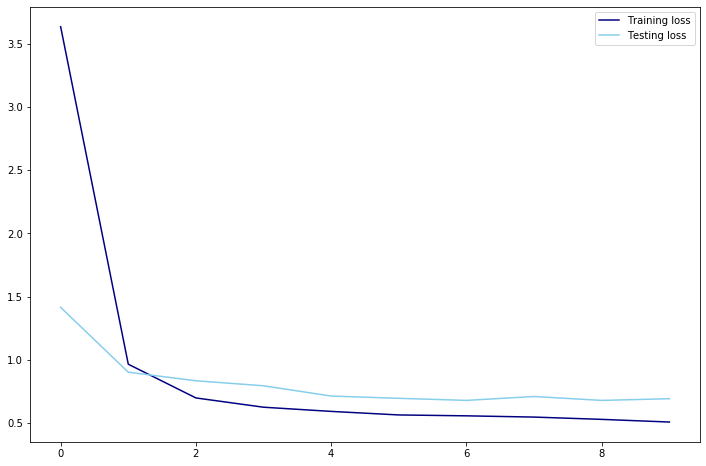

In [98]:
train_loss_all = history_all.history['loss']
test_loss_all = history_all.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss_all, label='Training loss', color='navy')
plt.plot(test_loss_all, label='Testing loss', color='skyblue')
plt.legend();

In [57]:
# for CountVectorizing
history_all.history['acc'][-1], history_all.history['val_acc'][-1]

(0.732659, 0.6854304671287537)

In [48]:
model_ffnn = Sequential()

lam=0.09
model_ffnn.add(Dense(n_input,
                   input_dim = n_input,
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(lam)
                       ))
model_dropout = Sequential()
model_dropout.add(Dropout(0.5))
model_ffnn.add(Dense(1,
                   activation='sigmoid'))

model_ffnn.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta=0, 
                           patience=5,
                           mode='auto')
history_all = model_ffnn.fit(X_train_tfidf,
                          y_train_tfidf,
                          validation_data=(X_test_tfidf,y_test_tfidf),
                          epochs=10,
                          batch_size=None,
                          verbose=2,
                          callbacks=[early_stop]
                          )

Train on 8996 samples, validate on 3020 samples
Epoch 1/10
 - 1s - loss: 2.2882 - acc: 0.5654 - val_loss: 0.7003 - val_acc: 0.5841
Epoch 2/10
 - 1s - loss: 0.6927 - acc: 0.5568 - val_loss: 0.6917 - val_acc: 0.5844
Epoch 3/10
 - 1s - loss: 0.6911 - acc: 0.5529 - val_loss: 0.6920 - val_acc: 0.5341
Epoch 4/10
 - 1s - loss: 0.6918 - acc: 0.5561 - val_loss: 0.6904 - val_acc: 0.5974
Epoch 5/10
 - 1s - loss: 0.6898 - acc: 0.5743 - val_loss: 0.6920 - val_acc: 0.5298
Epoch 6/10
 - 1s - loss: 0.6886 - acc: 0.5713 - val_loss: 0.6890 - val_acc: 0.5954
Epoch 7/10
 - 1s - loss: 0.6877 - acc: 0.5845 - val_loss: 0.6999 - val_acc: 0.5139
Epoch 8/10
 - 1s - loss: 0.6872 - acc: 0.5783 - val_loss: 0.6864 - val_acc: 0.6063
Epoch 9/10
 - 1s - loss: 0.6849 - acc: 0.5926 - val_loss: 0.6849 - val_acc: 0.5662
Epoch 10/10
 - 1s - loss: 0.6847 - acc: 0.5827 - val_loss: 0.6871 - val_acc: 0.5728


In [49]:
# for TfidfVectorizing
history_all.history['acc'][-1], history_all.history['val_acc'][-1]

(0.5827034, 0.5728476643562317)